In [1]:
# !pip install numpy pandas


In [1]:
import pandas as pd
import json

with open('user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)


C:\Users\Sajal Aggarwal\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def extract_amount(row):
    try:
        return float(row['actionData'].get('amount', 0))
    except:
        return 0.0

def extract_price(row):
    try:
        return float(row['actionData'].get('assetPriceUSD', 1.0))
    except:
        return 1.0

df['amount'] = df.apply(extract_amount, axis=1)
df['price_usd'] = df.apply(extract_price, axis=1)
df['value_usd'] = df['amount'] * df['price_usd']
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [3]:
df['deposit'] = df['action'] == 'deposit'
df['borrow'] = df['action'] == 'borrow'
df['repay'] = df['action'] == 'repay'
df['liquidationcall'] = df['action'] == 'liquidationcall'


In [4]:
grouped = df.groupby('userWallet').agg(
    tx_count=('action', 'count'),
    deposit_count=('deposit', 'sum'),
    borrow_count=('borrow', 'sum'),
    repay_count=('repay', 'sum'),
    liquidation_count=('liquidationcall', 'sum'),
    total_value_usd=('value_usd', 'sum'),
    total_deposit_usd=('value_usd', lambda x: x[df.loc[x.index, 'deposit']].sum()),
    total_borrow_usd=('value_usd', lambda x: x[df.loc[x.index, 'borrow']].sum()),
    total_repay_usd=('value_usd', lambda x: x[df.loc[x.index, 'repay']].sum()),
    first_tx=('timestamp', 'min'),
    last_tx=('timestamp', 'max')
).reset_index()

grouped['repay_borrow_ratio'] = grouped['total_repay_usd'] / (grouped['total_borrow_usd'] + 1e-6)
grouped['active_days'] = (grouped['last_tx'] - grouped['first_tx']).dt.days
grouped['avg_tx_value_usd'] = grouped['total_value_usd'] / grouped['tx_count']


In [5]:
!pip install scikit-learn

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Clean up and log transform
grouped['repay_borrow_ratio'] = grouped['repay_borrow_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
grouped['deposit_count'] = grouped['deposit_count'].fillna(0)
grouped['active_days'] = grouped['active_days'].fillna(0)
grouped['liquidation_count'] = grouped['liquidation_count'].fillna(0)

grouped['log_repay_ratio'] = np.log1p(grouped['repay_borrow_ratio'])
grouped['log_deposit_count'] = np.log1p(grouped['deposit_count'])
grouped['log_active_days'] = np.log1p(grouped['active_days'])
grouped['log_liquidations'] = np.log1p(grouped['liquidation_count'])

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(grouped[['log_repay_ratio', 'log_deposit_count', 'log_active_days', 'log_liquidations']])
scaled_df = pd.DataFrame(scaled, columns=['repay', 'deposit', 'active', 'liquidation'])

# Compute final score
grouped['score'] = (
    scaled_df['repay'] * 0.4 +
    scaled_df['deposit'] * 0.2 +
    scaled_df['active'] * 0.3 -
    scaled_df['liquidation'] * 0.3
) * 1000

grouped['score'] = grouped['score'].clip(lower=0, upper=1000)



In [6]:
# Final wallet and score output
# Select only wallet and score columns
output = grouped[['userWallet', 'score']].rename(columns={
    'userWallet': 'wallet'
})

# Optionally round score for readability
output['score'] = output['score'].round(2)

# View final result
print(output.head())




                                       wallet   score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6   22.22
1  0x000000000051d07a4fb3bd10121a343d85818da6   22.22
2  0x000000000096026fb41fc39f9875d164bd82e2dc  159.07
3  0x0000000000e189dd664b9ab08a33c4839953852c  289.91
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee  468.41


C:\Users\Sajal Aggarwal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


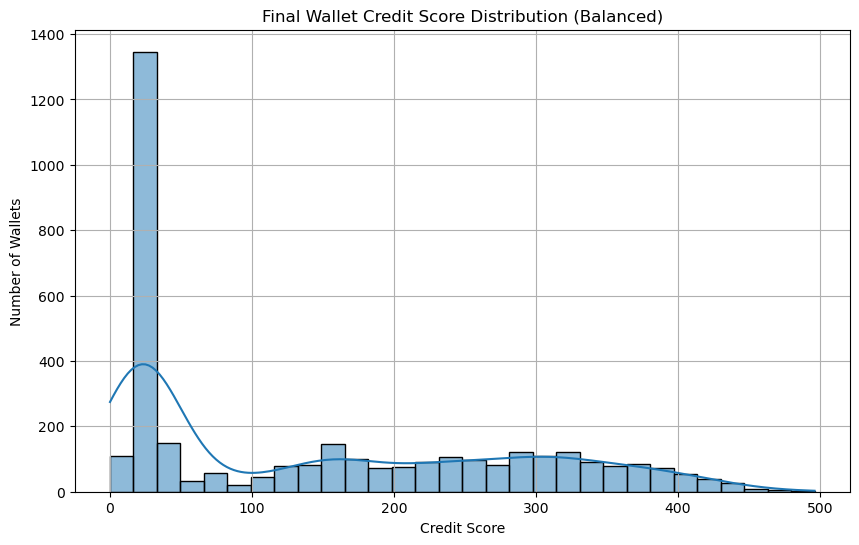

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(grouped['score'], bins=30, kde=True)
plt.title('Final Wallet Credit Score Distribution (Balanced)')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


score_band
Poor             1713
Below Average    1114
Average           670
Name: count, dtype: int64


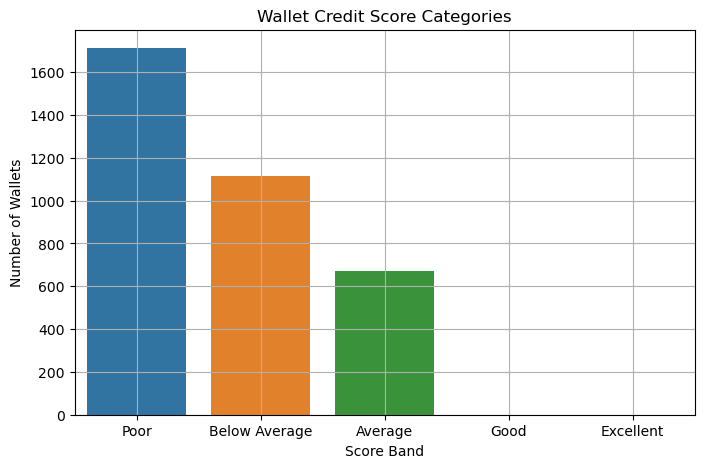

In [8]:
# Categorize credit score into bands
def categorize_score(score):
    if score >= 700:
        return 'Excellent'
    elif score >= 500:
        return 'Good'
    elif score >= 300:
        return 'Average'
    elif score >= 100:
        return 'Below Average'
    else:
        return 'Poor'

grouped['score_band'] = grouped['score'].apply(categorize_score)

# Count how many wallets fall into each band
print(grouped['score_band'].value_counts())

# Plot score band distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=grouped, x='score_band', order=['Poor', 'Below Average', 'Average', 'Good', 'Excellent'])
plt.title("Wallet Credit Score Categories")
plt.xlabel("Score Band")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


In [9]:
def assign_risk_label(score):
    if score < 100:
        return 'High Risk'
    elif score < 250:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply label
grouped['risk_label'] = grouped['score'].apply(assign_risk_label)

# Show counts
print(grouped['risk_label'].value_counts())


risk_label
High Risk      1713
Low Risk        979
Medium Risk     805
Name: count, dtype: int64


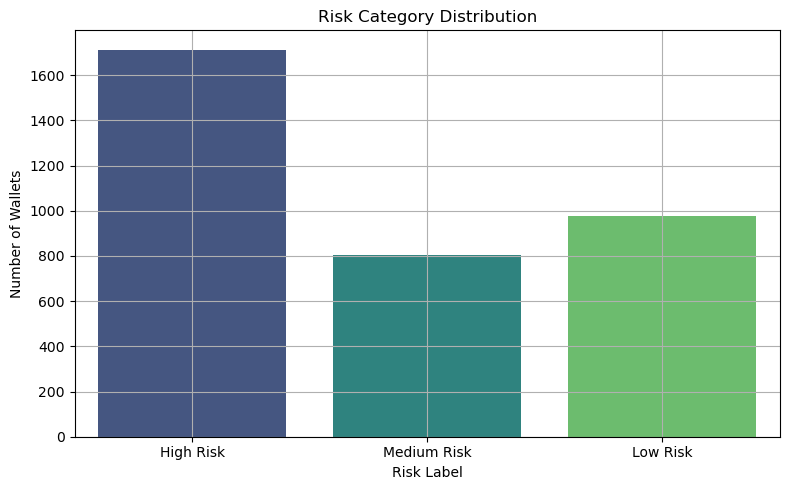

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='risk_label', data=grouped, palette='viridis')
plt.title("Risk Category Distribution")
plt.xlabel("Risk Label")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
output = grouped[['userWallet', 'score', 'risk_label']]
output = output.rename(columns={'userWallet': 'wallet'})
output.to_csv("wallet_risk_scores.csv", index=False)
print("Saved to wallet_risk_scores.csv")


Saved to wallet_risk_scores.csv


In [12]:
output.head()


,wallet,score,risk_label
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,22.222222,High Risk
1,0x000000000051d07a4fb3bd10121a343d85818da6,22.222222,High Risk
2,0x000000000096026fb41fc39f9875d164bd82e2dc,159.072557,Medium Risk
3,0x0000000000e189dd664b9ab08a33c4839953852c,289.909485,Low Risk
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,468.413735,Low Risk


In [14]:
summary = output.groupby('risk_label')['score'].describe()
print(summary)


              count        mean        std         min         25%  \
risk_label                                                           
High Risk    1713.0   25.772575  14.782874    0.000000   22.222222   
Low Risk      979.0  333.730055  52.265347  250.162252  291.311779   
Medium Risk   805.0  178.258136  41.135180  100.654541  147.456238   

                    50%         75%         max  
risk_label                                       
High Risk     22.222222   22.222222   98.727334  
Low Risk     326.447150  371.624003  496.068073  
Medium Risk  172.362947  216.552603  249.535090  
